In [1]:
import re
import os
import torch
import shutil
import librosa
import warnings

import mir_eval
import torch.nn as nn
import torch.optim as optim

import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from bs4 import BeautifulSoup
from os.path import join as ospj
from scipy.signal import find_peaks
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from bs4.builder import XMLParsedAsHTMLWarning
warnings.filterwarnings('ignore', category=XMLParsedAsHTMLWarning)

In [2]:
'''
    If things aren't running, try making the following command to copy the data locally:
        rsync -a /storage/datasets/IDMT-SMT-Drums /ssd/<your-user>/
'''

SAMPLING_RATE = 44100
BASEPATH = '/ssd/thiago.poppe/IDMT-SMT-Drums'

songnames = os.listdir(ospj(BASEPATH, 'audio/'))
songnames = list(map(lambda filename: filename.split('.')[0], songnames))

has_gpu = torch.cuda.is_available()
device = torch.device('cuda:0' if has_gpu else 'cpu')

print(f'{BASEPATH = }')
print('Running on device:', device)

BASEPATH = '/ssd/thiago.poppe/IDMT-SMT-Drums'
Running on device: cuda:0


## Helper functions to load and preprocess data

In [3]:
def calculate_spectrogram(y):
    spec = np.abs(librosa.cqt(y=y, sr=SAMPLING_RATE))
    spec = librosa.amplitude_to_db(spec, ref=np.max)
    
    return spec

def create_annotation_matrix(events, num_frames):
    instrument2index = {'HH': 0, 'SD': 1, 'KD': 2}
    annotations = np.zeros((3, num_frames), dtype=np.float32)
    
    for event in events:
        onset = float(event.onsetsec.string)
        instrument = event.instrument.string
        
        index = instrument2index[instrument]
        onset = librosa.time_to_frames(onset, sr=SAMPLING_RATE)
        annotations[index, onset] = 1.0
    
    return annotations


def create_feature_and_annotation(songname):
    audiofile = ospj(BASEPATH, f'audio/{songname}.wav')
    annotationfile = ospj(BASEPATH, f'annotation/{songname}.xml')
    
    with open(annotationfile, 'r') as fp:
        soup = BeautifulSoup(fp, 'lxml')
        events = soup.find_all('event')
    
    wave, sr = librosa.load(audiofile, sr=SAMPLING_RATE)
    spec = calculate_spectrogram(wave)
    annotation = create_annotation_matrix(events, spec.shape[1])
    
    return spec, annotation

## Chunkifying sequences

#### Creating required folders

In [4]:
if os.path.exists(ospj(BASEPATH, 'chunks')):
    print('Deleting chunks folder...')
    shutil.rmtree(ospj(BASEPATH, 'chunks'))

os.makedirs(ospj(BASEPATH, 'chunks'), exist_ok=True)
os.makedirs(ospj(BASEPATH, 'chunks/train'), exist_ok=True)
os.makedirs(ospj(BASEPATH, 'chunks/validation'), exist_ok=True)

Deleting chunks folder...


#### Splitting data into train and validation

In [5]:
def get_songname_type(songname):
    pattern = re.compile(r'([a-zA-Z]+)')
    matches = pattern.search(songname)
    
    # Returns songname type (RealDrum, WaveDrum or TechnoDrum)
    return matches.group(1)

songname_types = list(map(get_songname_type, songnames))
train_songnames, validation_songnames = train_test_split(songnames, test_size=0.2, random_state=42, stratify=songname_types)

#### Splitting data into multiple chunks

In [6]:
def chunkify(songname, window_size=512, hop_length=32):
    spec, annotation = create_feature_and_annotation(songname)
    num_frames = spec.shape[1]
    
    for i in range(0, num_frames - window_size + 1, hop_length):
        spec_chunk = spec[:, i:i+window_size]
        annotation_chunk = annotation[:, i:i+window_size]
        
        yield spec_chunk, annotation_chunk

In [7]:
print('Splitting train data...')
for songname in tqdm(train_songnames):
    for chunk_id, (spec, annotation) in enumerate(chunkify(songname)):
        filename = songname + f'_part{chunk_id:03d}'
        filename = ospj(BASEPATH, f'chunks/train/{filename}')
        np.savez(filename, spec=spec, annotation=annotation)
        
print('Splitting validation data...')
for songname in tqdm(validation_songnames):
    for chunk_id, (spec, annotation) in enumerate(chunkify(songname)):
        filename = songname + f'_part{chunk_id:03d}'
        filename = ospj(BASEPATH, f'chunks/validation/{filename}')
        np.savez(filename, spec=spec, annotation=annotation)

Splitting train data...


100%|██████████| 76/76 [00:08<00:00,  8.58it/s]


Splitting validation data...


100%|██████████| 19/19 [00:01<00:00, 10.08it/s]


## Training Neural Network (*Long-Short Term Memory* - LSTM)

#### Computing class imbalance weights in training set
- Class weights computed following the suggestions on the [PyTorch's BCEWithLogitsLoss webpage](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html#torch.nn.BCEWithLogitsLoss).

In [8]:
total_frames = 0
presence_counter = np.zeros(3)

for filename in tqdm(glob(ospj(BASEPATH, 'chunks/train/*.npz'))):
    data = np.load(filename)
    total_frames += data['annotation'].shape[1]
    presence_counter += (data['annotation'] == 1).sum(axis=1)

pos_weight = torch.from_numpy((total_frames - presence_counter) / presence_counter).to(device)
print('Class weights:', pos_weight)

100%|██████████| 1881/1881 [00:00<00:00, 2409.91it/s]


Class weights: tensor([26.5478, 74.0407, 52.0180], device='cuda:0', dtype=torch.float64)


#### Defining DataLoaders

In [9]:
class TranscriptionDataset(Dataset):
    CHUNKS_PATH = ospj(BASEPATH, 'chunks')
    
    def __init__(self, is_train: bool):
        split = 'train' if is_train else 'validation'
        self.filenames = glob(ospj(self.CHUNKS_PATH, split, '*.npz'))
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        data = np.load(self.filenames[idx])
        return data['spec'].T, data['annotation'].T

In [10]:
batch_size = 8

train_dataloader = DataLoader(TranscriptionDataset(is_train=True), batch_size, shuffle=True)
validation_dataloader = DataLoader(TranscriptionDataset(is_train=False), batch_size, shuffle=False)

In [11]:
# Checking if DataLoader output has correct shape
for X, y in train_dataloader:
    break

X.shape, y.shape

(torch.Size([8, 512, 84]), torch.Size([8, 512, 3]))

#### Defining model

In [12]:
class SimpleLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size=84, hidden_size=256, num_layers=2, 
                            dropout=0.5, batch_first=True, bidirectional=False)
        
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(), nn.Dropout(),
            nn.Linear(128, 64),
            nn.ReLU(), nn.Dropout(),
            nn.Linear(64, 32),
            nn.ReLU(), nn.Dropout(),
            nn.Linear(32, 3)
        )
        
    def forward(self, x: torch.tensor):
        outputs, _ = self.lstm(x)
        return self.classifier(outputs)

In [13]:
model = SimpleLSTM().to('cuda')
model

SimpleLSTM(
  (lstm): LSTM(84, 256, num_layers=2, batch_first=True, dropout=0.5)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=32, out_features=3, bias=True)
  )
)

In [14]:
num_parameters = sum(p.numel() for p in model.lstm.parameters())
print('Number of model parameters:', num_parameters)

Number of model parameters: 876544


In [15]:
# Checking if forward is correct
for X, y in train_dataloader:
    X = X.to(device)
    y = y.to(device)
    break
    
outputs = model(X)
assert outputs.shape == y.shape

In [16]:
# Checking if loss function works
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
criterion(outputs, y)

tensor(1.4004, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

#### Running training script

In [17]:
def evaluate(model, validation_dataloader, criterion):
    val_loss = []
    
    model.eval()
    with torch.no_grad():
        for X, y in validation_dataloader:
            X = X.to(device)
            y = y.to(device)
            
            outputs = model(X)
            loss = criterion(outputs, y)
            val_loss.append(loss.item())
            
    val_loss = np.mean(val_loss)
    return val_loss        

In [18]:
num_epochs = 50
learning_rate = 0.001

model = SimpleLSTM().to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.25)

last_validation_loss = None
best_validation_loss = np.inf

no_change_counter = 0
loss_limit_iterations = 5
loss_difference_epsilon = 1e-2

for epoch in range(1, num_epochs + 1):
    model.train()
    epoch_loss = []
    
    for X, y in train_dataloader:
        X = X.to(device)
        y = y.to(device)
        outputs = model(X)

        optimizer.zero_grad()
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())
    
    train_loss = np.mean(epoch_loss)
    validation_loss = evaluate(model, validation_dataloader, criterion)

    if last_validation_loss is not None and np.abs(last_validation_loss - validation_loss) < loss_difference_epsilon:
        no_change_counter += 1
        print(f"validation loss didn't decrease [{no_change_counter}/{loss_limit_iterations}]")

        if no_change_counter == loss_limit_iterations:
            print('ending training loop...')
            break
    else:
        no_change_counter = 0
        last_validation_loss = validation_loss
    
    if validation_loss < best_validation_loss:
        print('Saving new best model...')
        best_validation_loss = validation_loss
        torch.save(model.state_dict(), 'cqt_simple_lstm_model.ckpt')

    lr_scheduler.step()
    print(f'[epoch {epoch}/{num_epochs}] --> train loss: {train_loss:.5f}, validation loss: {validation_loss:5f}')

Saving new best model...
[epoch 1/50] --> train loss: 0.75311, validation loss: 0.419147
Saving new best model...
[epoch 2/50] --> train loss: 0.54469, validation loss: 0.368477
validation loss didn't decrease [1/5]
Saving new best model...
[epoch 3/50] --> train loss: 0.51462, validation loss: 0.363827
Saving new best model...
[epoch 4/50] --> train loss: 0.49487, validation loss: 0.344692
validation loss didn't decrease [1/5]
Saving new best model...
[epoch 5/50] --> train loss: 0.47370, validation loss: 0.341247
Saving new best model...
[epoch 6/50] --> train loss: 0.42440, validation loss: 0.329373
validation loss didn't decrease [1/5]
Saving new best model...
[epoch 7/50] --> train loss: 0.40097, validation loss: 0.327682
validation loss didn't decrease [2/5]
[epoch 8/50] --> train loss: 0.38582, validation loss: 0.329446
[epoch 9/50] --> train loss: 0.36922, validation loss: 0.352160
validation loss didn't decrease [1/5]
[epoch 10/50] --> train loss: 0.35703, validation loss: 0.3

#### Checking validation metrics

- We will compute the mean BPM of our whole dataset. This will guide us to tune the ``peak_pick`` algorithm.
- Considering a sixthteen note as being our smallest rhythm figure ``peak_pick`` algorithm must have this distance between each note.

In [19]:
tempos = []

for filename in tqdm(glob(ospj(BASEPATH, 'audio/*.wav'))):
    wave, sr = librosa.load(filename, sr=SAMPLING_RATE)
    tempos.append(librosa.feature.tempo(y=wave, sr=sr))
    
mean_tempo = np.mean(tempos)
print(f'Mean tempo (BPM): {mean_tempo:.5f}')

100%|██████████| 95/95 [00:11<00:00,  8.10it/s]

Mean tempo (BPM): 115.74726


In [20]:
tempo_of_sixthteen = (60 / mean_tempo) / 8
peak_distance = librosa.time_to_frames(tempo_of_sixthteen, sr=SAMPLING_RATE)

print('Peak distance to be used:', peak_distance)

Peak distance to be used: 5


In [21]:
sigmoid = nn.Sigmoid()
peak_picking_params = {'height': 0.85, 'distance': peak_distance}

best_model = SimpleLSTM().to(device)
best_model.load_state_dict(torch.load('cqt_simple_lstm_model.ckpt'))

total_size = 0
recall_scores = np.zeros(3)
fmeasure_scores = np.zeros(3)
precision_scores = np.zeros(3)

best_model.eval()
with torch.no_grad():
    for X, y in validation_dataloader:
        X = X.to(device)
        y = y.to(device)

        outputs = best_model(X)
        y_numpy = y.detach().cpu().numpy()
        probabilities = sigmoid(outputs).detach().cpu().numpy()

        total_size += outputs.shape[0]
        for batch_idx in range(outputs.shape[0]):        
            for instrument in range(3):
                reference_onsets = np.where(y_numpy[batch_idx, :, instrument])[0]
                reference_onsets = librosa.frames_to_time(reference_onsets, sr=SAMPLING_RATE)

                estimated_onsets = find_peaks(probabilities[batch_idx, :, instrument], **peak_picking_params)[0]
                estimated_onsets = librosa.frames_to_time(estimated_onsets, sr=SAMPLING_RATE)

                if len(reference_onsets) != 0 and len(estimated_onsets) != 0:
                    metrics = mir_eval.onset.evaluate(reference_onsets, estimated_onsets, window_size=2*tempo_of_sixthteen)
                    recall_scores[instrument] += metrics['Recall']
                    fmeasure_scores[instrument] += metrics['F-measure']
                    precision_scores[instrument] += metrics['Precision']

recall_scores /= total_size
fmeasure_scores /= total_size
precision_scores /= total_size

In [22]:
for i, instrument in enumerate(['Hi-Hat', 'Snare Drum', 'Kick Drum']):
    print(f'{instrument} metrics:')
    print(f'  - Mean Recall: {recall_scores[i]:5f}')
    print(f'  - Mean Precision: {precision_scores[i]:5f}')
    print(f'  - Mean F-Measure: {fmeasure_scores[i]:5f}')
    print()
    
print('Overall drumkit metrics:')
print(f'  - Mean Recall: {np.mean(recall_scores):5f}')
print(f'  - Mean Precision: {np.mean(precision_scores):5f}')
print(f'  - Mean F-Measure: {np.mean(fmeasure_scores):5f}')

Hi-Hat metrics:
  - Mean Recall: 0.795697
  - Mean Precision: 0.849389
  - Mean F-Measure: 0.806316

Snare Drum metrics:
  - Mean Recall: 0.983664
  - Mean Precision: 0.703550
  - Mean F-Measure: 0.791867

Kick Drum metrics:
  - Mean Recall: 0.980917
  - Mean Precision: 0.983007
  - Mean F-Measure: 0.980385

Overall drumkit metrics:
  - Mean Recall: 0.920093
  - Mean Precision: 0.845315
  - Mean F-Measure: 0.859523


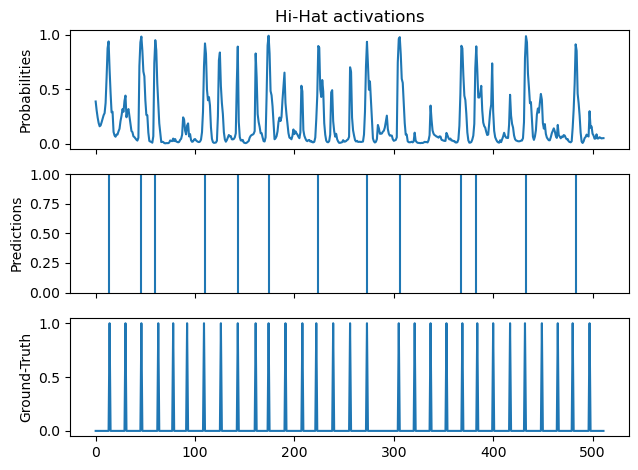

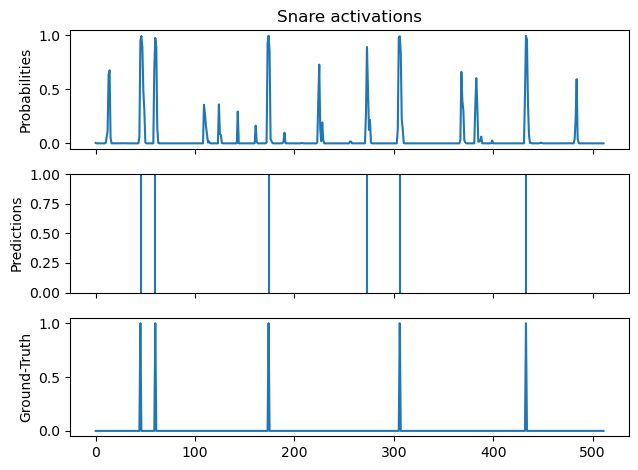

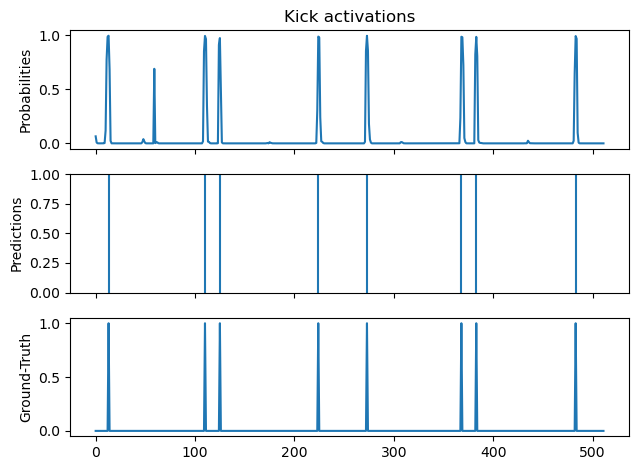

In [23]:
y_numpy = y.detach().cpu().numpy()
outputs = best_model(X.to(device))
probabilities = sigmoid(outputs).detach().cpu().numpy()

for i, instrument in enumerate(['Hi-Hat', 'Snare', 'Kick']):
    estimated_onsets = find_peaks(probabilities[0, :, i], **peak_picking_params)[0]
    
    fig, axs = plt.subplots(3, 1, sharex=True)
    axs[0].set_title(f'{instrument} activations')
    axs[0].set_ylabel('Probabilities')
    axs[0].plot(probabilities[0, :, i])
    
    axs[1].set_ylabel('Predictions')
    for onset in estimated_onsets:
        axs[1].axvline(onset)
    
    axs[2].set_ylabel('Ground-Truth')
    axs[2].plot(y_numpy[0, :, i])
    
    fig.tight_layout()